In [14]:
from matplotlib import pyplot as plt
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from torch.nn import functional as F
import torch
import kagglehub
import platform

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PATH = 'samples/*.png'

In [15]:
PATH = kagglehub.dataset_download("fournierp/captcha-version-2-images") + '/' + PATH # if u DONT have samples already downloded

**loading sample images and extracting their labels**

In [16]:
pics = {}
for image_file in glob(PATH):
    if (platform.system() == 'Linux'):
        label = image_file.split('/')[-1].split('.')[0] # pentru linux
    else:
        label = image_file.split('\\')[-1].split('.')[0]
    with Image.open(image_file) as pic:
        pics[label] = np.asarray(pic)


**tensorize data**

In [17]:
x = list(map(transforms.ToTensor(), pics.values()))
y = list(map(list, pics.keys()))


encoder = OneHotEncoder().fit(y)
y_encoded = encoder.transform(y).toarray()


**test and train split**

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y_encoded, test_size=0.33, random_state=42)


x_train = torch.stack(x_train)
x_test = torch.stack(x_test)
y_train = torch.tensor(y_train)

**define and instantiation of CNN**

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(4, 24, kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=2),
            nn.Dropout(0.2),
            nn.Conv2d(24, 48, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
        )
        self.fc = nn.Linear(5760, 95)

    def forward(self, x):
        x = self.feats(x)
        x = x.flatten(1)
        x = self.fc(F.relu(x))
        return F.softmax(x, -1)

model = CNN()
model.double().to(DEVICE)

error = nn.BCELoss()
opt = optim.Adam(model.parameters())

y_t = y_train.to(DEVICE)
x_t = x_train.double().to(DEVICE)

**model training**

In [20]:
def train(x, y, num_epochs=1000):
    model.train()
    for epoch in range(1, 1 + num_epochs):
        opt.zero_grad()
        out = model(x.double().to(DEVICE))
        loss = error(out, y_t)
        loss.backward()
        opt.step()
        if epoch % int(0.1 * num_epochs) == 0:
            print(f'Epoch: {epoch} \t loss: {loss.item()}')

train(x_t, y_t)

with torch.no_grad():
    out = model(x_test.double().to(DEVICE)).cpu().detach().numpy()

Epoch: 100 	 loss: 0.10278960180338811
Epoch: 200 	 loss: 0.09523752057634362
Epoch: 300 	 loss: 0.09350733296024853
Epoch: 400 	 loss: 0.09246173066526697
Epoch: 500 	 loss: 0.09177974856472042
Epoch: 600 	 loss: 0.091067936188844
Epoch: 700 	 loss: 0.09058432044293599
Epoch: 800 	 loss: 0.09032603212772496
Epoch: 900 	 loss: 0.08980668785959137
Epoch: 1000 	 loss: 0.08963791131544897


encoding, showing results and calculting score

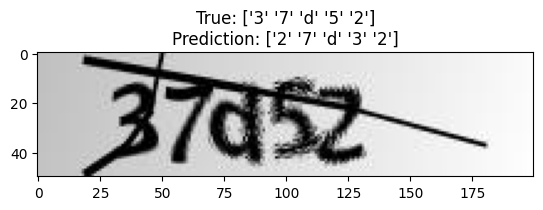

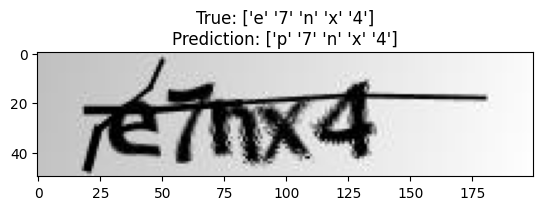

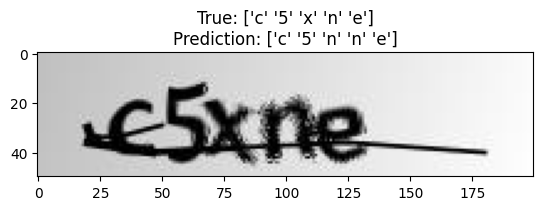

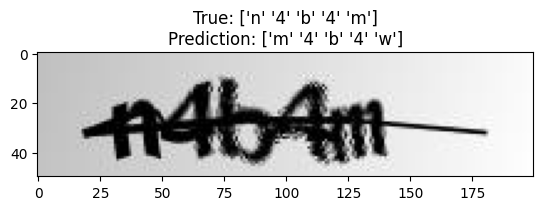

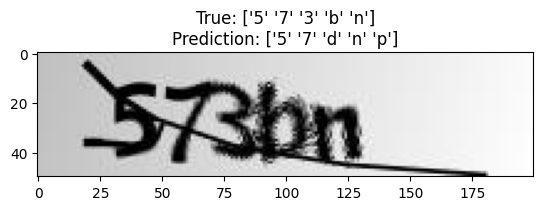

Accuracy: 65.81%


In [13]:
res = encoder.inverse_transform(out)
true = encoder.inverse_transform(y_test)

test_images = list(map(transforms.ToPILImage(), x_test))

for s in np.random.choice(len(x_test) - 1, size=5):
    plt.title(f'True: {true[s]}\nPrediction: {res[s]}')
    plt.imshow(test_images[s])
    plt.show()


def score_calculator(true, res):
    score = []
    for x, y in zip(true, res):
        if all(x == y):
            score.append(1)
        elif any(x == y):
            score.append(sum(x == y) / len(x))
        else:
            score.append(0)
    return sum(score) / len(score) * 100

print(f'Accuracy: {score_calculator(true, res):.4g}%')